Step 1: Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

Step 2: Loading Dataset


In [4]:
df = pd.read_csv("data.csv", encoding="latin-1")
print(df.columns)

Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')


/tmp/ipython-input-3103754883.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin-1")


Step 3: Extracting the NO2 feature

In [6]:
x = df["no2"].dropna().values.astype(np.float32)

# Normalizing
x = (x - np.mean(x)) / np.std(x)

print("Number of samples:", len(x))

Number of samples: 419509


Step 4: Transformation

In [7]:
r = 102317191
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)

z = x + a_r * np.sin(b_r * x)

print("a_r =", a_r)
print("b_r =", b_r)

a_r = 2.0
b_r = 0.6


Step 5: Converting to Tensor

In [8]:
z_tensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)

Step 6: GAN Architecture

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


Step 7: Models

In [11]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)


Step 8: Training GAN

In [12]:
epochs = 3000
batch_size = 128

for epoch in range(epochs):
    idx = torch.randint(0, len(z_tensor), (batch_size,))
    real_z = z_tensor[idx]

    noise = torch.randn(batch_size, 1)
    fake_z = G(noise)

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    d_loss = (
        criterion(D(real_z), real_labels) +
        criterion(D(fake_z.detach()), fake_labels)
    )

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    noise = torch.randn(batch_size, 1)
    fake_z = G(noise)
    g_loss = criterion(D(fake_z), real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.4316 | G Loss: 0.6473
Epoch 500 | D Loss: 1.3376 | G Loss: 0.7132
Epoch 1000 | D Loss: 1.3821 | G Loss: 0.6934
Epoch 1500 | D Loss: 1.3861 | G Loss: 0.7059
Epoch 2000 | D Loss: 1.3794 | G Loss: 0.6508
Epoch 2500 | D Loss: 1.3918 | G Loss: 0.7221


Step 9: Samples generating

In [13]:
with torch.no_grad():
    noise = torch.randn(10000, 1)
    z_fake = G(noise).numpy()


Step 10: PDF Approximation

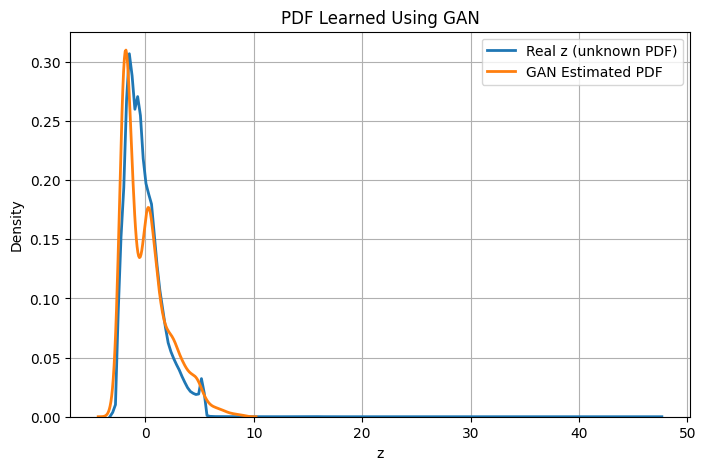

In [14]:
plt.figure(figsize=(8, 5))

sns.kdeplot(z, label="Real z (unknown PDF)", linewidth=2)
sns.kdeplot(z_fake.flatten(), label="GAN Estimated PDF", linewidth=2)

plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learned Using GAN")
plt.legend()
plt.grid(True)
plt.show()
